In [2]:
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [3]:
conn = sqlite3.connect('cycling_data.db')
cursor = conn.execute('SELECT * FROM cycling_data')  # Make sure 'bar' is your actual table name

# Retrieve and print column names
names = [description[0] for description in cursor.description]
print("Column names:", names)

Column names: ['rental_id', 'duration', 'bike_id', 'end_date', 'end_station_id', 'end_station_name', 'start_date', 'start_station_id', 'start_station_name']


In [3]:
# Check columns in the cycling_data table
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(cycling_data);")
columns_info = cursor.fetchall()

for col in columns_info:
    print(col)


(0, 'rental_id', 'INTEGER', 0, None, 1)
(1, 'duration', 'INTEGER', 0, None, 0)
(2, 'bike_id', 'INTEGER', 0, None, 0)
(3, 'end_date', 'TEXT', 0, None, 0)
(4, 'end_station_id', 'INTEGER', 0, None, 0)
(5, 'end_station_name', 'TEXT', 0, None, 0)
(6, 'start_date', 'TEXT', 0, None, 0)
(7, 'start_station_id', 'INTEGER', 0, None, 0)
(8, 'start_station_name', 'TEXT', 0, None, 0)


In [4]:
# Reconnect to the SQLite database if necessary
conn = sqlite3.connect('cycling_data.db')
cur = conn.cursor()

# Retrieve the first five rows from the cycling_data_clean table
cur.execute("SELECT * FROM cycling_data LIMIT 5;")
rows = cur.fetchall()

# Fetch and print column names
column_names = [description[0] for description in cur.description]
print("Column Names:", column_names)

# Print the rows
for row in rows:
    print(row)



Column Names: ['rental_id', 'duration', 'bike_id', 'end_date', 'end_station_id', 'end_station_name', 'start_date', 'start_station_id', 'start_station_name']
(104748248, 1500, 16017, '30/12/2020 00:26', 541, 'Green Park Station, Mayfair', '30/12/2020 00:01', 291, 'Claverton Street, Pimlico')
(104748249, 360, 18049, '30/12/2020 00:07', 363, "Lord's, St. John's Wood", '30/12/2020 00:01', 114, "Park Road (Baker Street), The Regent's Park")
(104748250, 420, 18992, '30/12/2020 00:09', 128, "Emperor's Gate, South Kensington", '30/12/2020 00:02', 29, 'Hereford Road, Bayswater')
(104748251, 480, 19831, '30/12/2020 00:10', 133, 'Derry Street, Kensington', '30/12/2020 00:02', 219, "Bramham Gardens, Earl's Court")
(104748252, 1500, 3496, '30/12/2020 00:27', 541, 'Green Park Station, Mayfair', '30/12/2020 00:02', 291, 'Claverton Street, Pimlico')


In [5]:
# SQL query to check for missing values
query = """
SELECT
    COUNT(*) AS total_rows,
    COUNT(rental_id) AS rental_id_non_null,
    COUNT(duration) AS duration_non_null,
    COUNT(bike_id) AS bike_id_non_null,
    COUNT(end_date) AS end_date_non_null,
    COUNT(end_station_id) AS end_station_id_non_null,
    COUNT(end_station_name) AS end_station_name_non_null,
    COUNT(start_date) AS start_date_non_null,
    COUNT(start_station_id) AS start_station_id_non_null,
    COUNT(start_station_name) AS start_station_name_non_null,
    (COUNT(*) - COUNT(rental_id)) AS rental_id_missing,
    (COUNT(*) - COUNT(duration)) AS duration_missing,
    (COUNT(*) - COUNT(bike_id)) AS bike_id_missing,
    (COUNT(*) - COUNT(end_date)) AS end_date_missing,
    (COUNT(*) - COUNT(end_station_id)) AS end_station_id_missing,
    (COUNT(*) - COUNT(end_station_name)) AS end_station_name_missing,
    (COUNT(*) - COUNT(start_date)) AS start_date_missing,
    (COUNT(*) - COUNT(start_station_id)) AS start_station_id_missing,
    (COUNT(*) - COUNT(start_station_name)) AS start_station_name_missing
FROM
    cycling_data;
"""

# Execute the query and fetch the results
missing_values = conn.execute(query).fetchone()

# Print the results
print("Missing values check:")
print(f"Total rows: {missing_values[0]}")
print(f"Non-null values in rental_id: {missing_values[1]}, Missing: {missing_values[10]}")
print(f"Non-null values in duration: {missing_values[2]}, Missing: {missing_values[11]}")
print(f"Non-null values in bike_id: {missing_values[3]}, Missing: {missing_values[12]}")
print(f"Non-null values in end_date: {missing_values[4]}, Missing: {missing_values[13]}")
print(f"Non-null values in end_station_id: {missing_values[5]}, Missing: {missing_values[14]}")
print(f"Non-null values in end_station_name: {missing_values[6]}, Missing: {missing_values[15]}")
print(f"Non-null values in start_date: {missing_values[7]}, Missing: {missing_values[16]}")
print(f"Non-null values in start_station_id: {missing_values[8]}, Missing: {missing_values[17]}")
print(f"Non-null values in start_station_name: {missing_values[9]}, Missing: {missing_values[18]}")


Missing values check:
Total rows: 17074695
Non-null values in rental_id: 17074695, Missing: 0
Non-null values in duration: 17074695, Missing: 0
Non-null values in bike_id: 17074695, Missing: 0
Non-null values in end_date: 17074695, Missing: 0
Non-null values in end_station_id: 17074695, Missing: 0
Non-null values in end_station_name: 17074695, Missing: 0
Non-null values in start_date: 17074695, Missing: 0
Non-null values in start_station_id: 17074695, Missing: 0
Non-null values in start_station_name: 17074695, Missing: 0


In [29]:
queries = [
    "SELECT COUNT(*) AS total_journeys FROM cycling_data;",
    "SELECT MIN(start_date) AS start_date, MAX(end_date) AS end_date FROM cycling_data;",
    "SELECT SUM(duration) / 60 AS total_duration_minutes FROM cycling_data;",
    "SELECT COUNT(DISTINCT bike_id) AS unique_bikes FROM cycling_data;",
    "SELECT AVG(duration) / 60 AS average_duration_minutes FROM cycling_data;",
    "SELECT COUNT(*) / COUNT(DISTINCT bike_id) AS average_journey_per_bike FROM cycling_data;",
    "SELECT strftime('%w', start_date) AS weekday, COUNT(*) AS journeys FROM cycling_data GROUP BY weekday ORDER BY weekday;",
    "SELECT strftime('%H', start_date) AS hour, COUNT(*) AS journeys FROM cycling_data GROUP BY hour ORDER BY hour;",
    "SELECT MAX(duration) / 60 AS longest_journey, MIN(duration) / 60 AS shortest_journey FROM cycling_data;",
    "SELECT start_station_name, end_station_name, COUNT(*) AS route_count FROM cycling_data GROUP BY start_station_name, end_station_name ORDER BY route_count DESC LIMIT 10;",
    "SELECT bike_id, COUNT(*) AS journey_count FROM cycling_data GROUP BY bike_id ORDER BY journey_count DESC LIMIT 10;"
]

# Execute each query and print the results
for query in queries:
    cursor.execute(query)
    rows = cursor.fetchall()
    print(f"\nQuery: {query}")
    for row in rows:
        print(row)


Query: SELECT COUNT(*) AS total_journeys FROM cycling_data;
(17074695,)

Query: SELECT MIN(start_date) AS start_date, MAX(end_date) AS end_date FROM cycling_data;
('01/01/2021 00:00', '31/12/2021 23:59')

Query: SELECT SUM(duration) / 60 AS total_duration_minutes FROM cycling_data;
(364818337,)

Query: SELECT COUNT(DISTINCT bike_id) AS unique_bikes FROM cycling_data;
(16622,)

Query: SELECT AVG(duration) / 60 AS average_duration_minutes FROM cycling_data;
(21.36602363907525,)

Query: SELECT COUNT(*) / COUNT(DISTINCT bike_id) AS average_journey_per_bike FROM cycling_data;
(1027,)

Query: SELECT strftime('%w', start_date) AS weekday, COUNT(*) AS journeys FROM cycling_data GROUP BY weekday ORDER BY weekday;
(None, 17074695)

Query: SELECT strftime('%H', start_date) AS hour, COUNT(*) AS journeys FROM cycling_data GROUP BY hour ORDER BY hour;
(None, 17074695)

Query: SELECT MAX(duration) / 60 AS longest_journey, MIN(duration) / 60 AS shortest_journey FROM cycling_data;
(9791, 1)

Query: SE

In [28]:
# Create a cursor object using the cursor method
cursor = conn.cursor()

# SQL query to fetch the statistical summary
query = """
SELECT AVG(duration) AS average_duration, 
       MIN(duration) AS min_duration, 
       MAX(duration) AS max_duration        
FROM cycling_data;
"""

# Execute the query
cursor.execute(query)

# Fetch and print the result, converting from seconds to minutes
result = cursor.fetchone()
print(f"Average Duration: {result[0] / 60:.2f} minutes")  # Converting average duration from seconds to minutes
print(f"Minimum Duration: {result[1] / 60:.2f} minutes")  # Converting minimum duration from seconds to minutes
print(f"Maximum Duration: {result[2] / 60:.2f} minutes")  # Converting maximum duration from seconds to minutes


Average Duration: 21.37 minutes
Minimum Duration: 1.00 minutes
Maximum Duration: 9791.00 minutes


In [8]:
cur.execute('''
SELECT start_station_name, COUNT(*) AS num_rentals
FROM cycling_data
GROUP BY start_station_name
ORDER BY num_rentals DESC
LIMIT 25;
''')

results = cur.fetchall()
print("Count of Rentals per Station (Top 10):")
for row in results:
    print(f"Station: {row[0]}, Rentals: {row[1]}")
print()


Count of Rentals per Station (Top 10):
Station: Hyde Park Corner, Hyde Park, Rentals: 139079
Station: Wellington Arch, Hyde Park, Rentals: 90265
Station: Albert Gate, Hyde Park, Rentals: 86764
Station: Westminster Pier, Westminster, Rentals: 80371
Station: Hop Exchange, The Borough, Rentals: 77948
Station: Black Lion Gate, Kensington Gardens, Rentals: 77918
Station: Aquatic Centre, Queen Elizabeth Olympic Park, Rentals: 77155
Station: Duke Street Hill, London Bridge, Rentals: 70941
Station: Wormwood Street, Liverpool Street, Rentals: 68281
Station: Serpentine Car Park, Hyde Park, Rentals: 68079
Station: Belgrove Street , King's Cross, Rentals: 67635
Station: Park Lane , Hyde Park, Rentals: 67315
Station: Waterloo Station 3, Waterloo, Rentals: 66432
Station: Triangle Car Park, Hyde Park, Rentals: 65377
Station: Tooley Street, Bermondsey, Rentals: 64790
Station: Tower Gardens , Tower, Rentals: 64721
Station: Waterloo Station 1, Waterloo, Rentals: 63971
Station: Brushfield Street, Liverpo

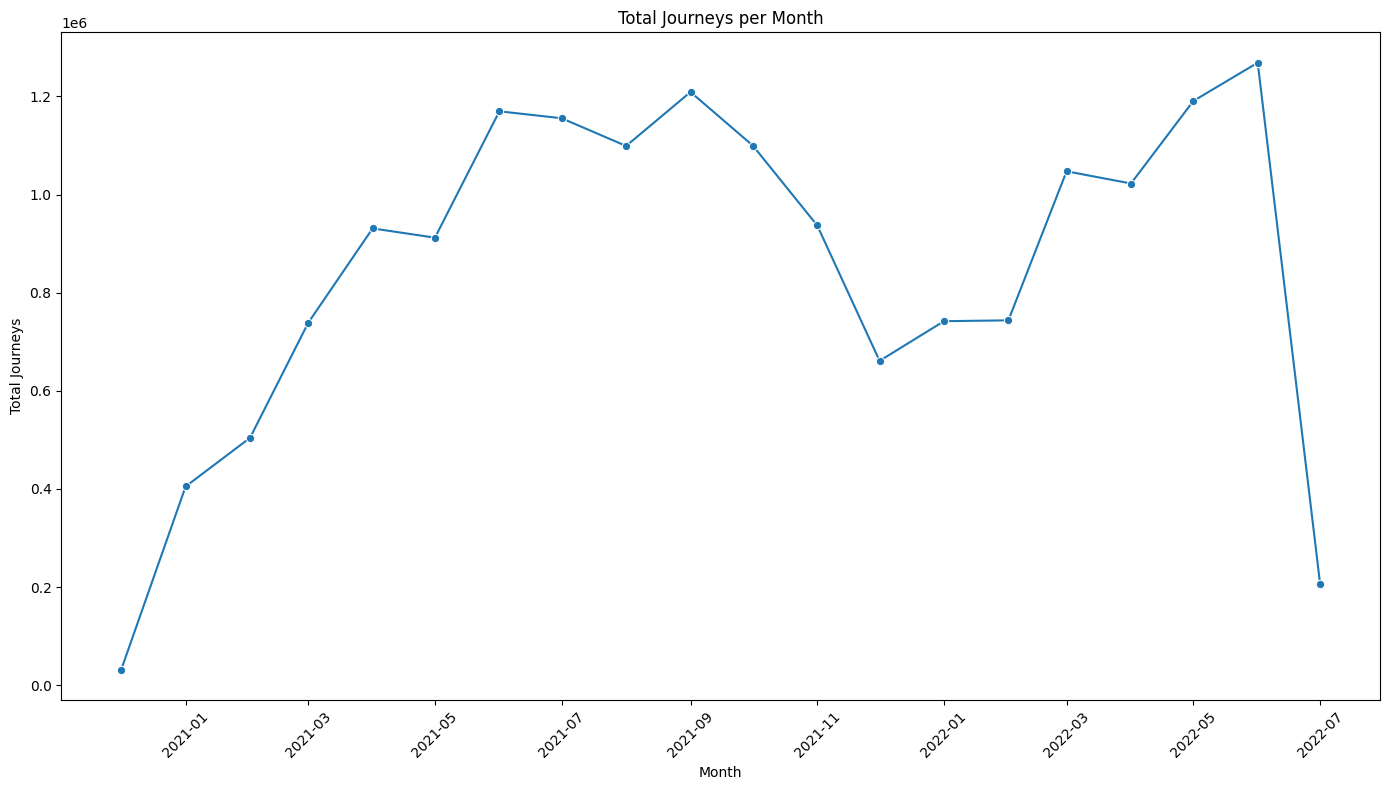

In [9]:
query = """
SELECT strftime('%Y-%m', substr(start_date, 7, 4) || '-' || substr(start_date, 4, 2) || '-01') AS year_month, 
       COUNT(*) AS total_journeys
FROM cycling_data
GROUP BY year_month
ORDER BY year_month;
"""

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Ensure year_month is in datetime format for plotting
df['year_month'] = pd.to_datetime(df['year_month'])

# Plotting with seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='year_month', y='total_journeys', marker='o', linestyle='-')

plt.title('Total Journeys per Month')
plt.xlabel('Month')
plt.ylabel('Total Journeys')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout

plt.show()

In [11]:
cur.execute('''
SELECT strftime('%Y-%m-%d', start_date) AS rental_date, COUNT(*) AS num_rentals
FROM cycling_data
GROUP BY rental_date
ORDER BY rental_date;
''')

# Fetch and print a subset of the results
results = cur.fetchmany(10)
print("Number of Rentals Over Time (First 10 days):")
for row in results:
    print(f"Date: {row[0]}, Number of Rentals: {row[1]}")
print()


Number of Rentals Over Time (First 10 days):
Date: None, Number of Rentals: 17074695



In [12]:
query = """
SELECT start_station_name, end_station_name, COUNT(*) AS num_journeys
FROM cycling_data
GROUP BY start_station_name, end_station_name
ORDER BY num_journeys DESC;
"""

# Execute the query and load the results into a pandas DataFrame
df_routes = pd.read_sql_query(query, conn)

# Display the first few rows of the DataFrame
print(df_routes.head(20))


                              start_station_name  \
0   Aquatic Centre, Queen Elizabeth Olympic Park   
1                    Hyde Park Corner, Hyde Park   
2                         Albert Gate, Hyde Park   
3                          Park Lane , Hyde Park   
4            Black Lion Gate, Kensington Gardens   
5                   Triangle Car Park, Hyde Park   
6           Podium, Queen Elizabeth Olympic Park   
7                     Wellington Arch, Hyde Park   
8                 Serpentine Car Park, Hyde Park   
9                    Hyde Park Corner, Hyde Park   
10  Aquatic Centre, Queen Elizabeth Olympic Park   
11    Timber Lodge, Queen Elizabeth Olympic Park   
12               Palace Gate, Kensington Gardens   
13    East Village, Queen Elizabeth Olympic Park   
14                   Hyde Park Corner, Hyde Park   
15                   Hyde Park Corner, Hyde Park   
16                        Albert Gate, Hyde Park   
17                  Triangle Car Park, Hyde Park   
18          

C:\Users\jackb\AppData\Local\Temp\ipykernel_37584\2118882196.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')


     weekday  total_journeys
0     Friday         2410792
1     Monday         2220852
2   Saturday         2693628
3     Sunday         2293004
4   Thursday         2517320
5    Tuesday         2464428
6  Wednesday         2474671


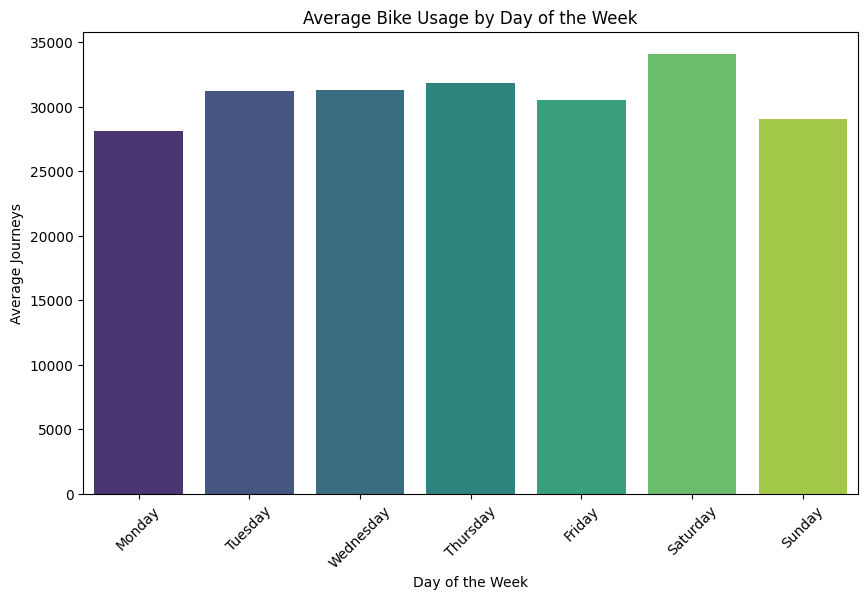

In [13]:
# Fetch the basic data
query = "SELECT start_date FROM cycling_data;"
df = pd.read_sql_query(query, conn)

# Convert start_date to datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')

# Extract day of the week
df['weekday'] = df['start_date'].dt.day_name()

# Aggregate by weekday
df_weekday_avg = df.groupby('weekday')['start_date'].count().reset_index(name='total_journeys')

print(df_weekday_avg)

# Assuming 'start_date' has been converted to datetime format
df['date'] = df['start_date'].dt.date  # Extract just the date part for grouping
daily_totals = df.groupby('date').size().reset_index(name='total_journeys')

daily_totals['date'] = pd.to_datetime(daily_totals['date'])  # Ensure 'date' is in datetime format
daily_totals['weekday'] = daily_totals['date'].dt.day_name()  # Get weekday names

weekday_avg = daily_totals.groupby('weekday')['total_journeys'].mean().reset_index(name='avg_journeys')

# Reorder the DataFrame based on the day of the week
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_avg['weekday'] = pd.Categorical(weekday_avg['weekday'], categories=ordered_days, ordered=True)
weekday_avg = weekday_avg.sort_values('weekday')


import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='avg_journeys', data=weekday_avg, palette='viridis')

plt.title('Average Bike Usage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Journeys')
plt.xticks(rotation=45)

plt.show()

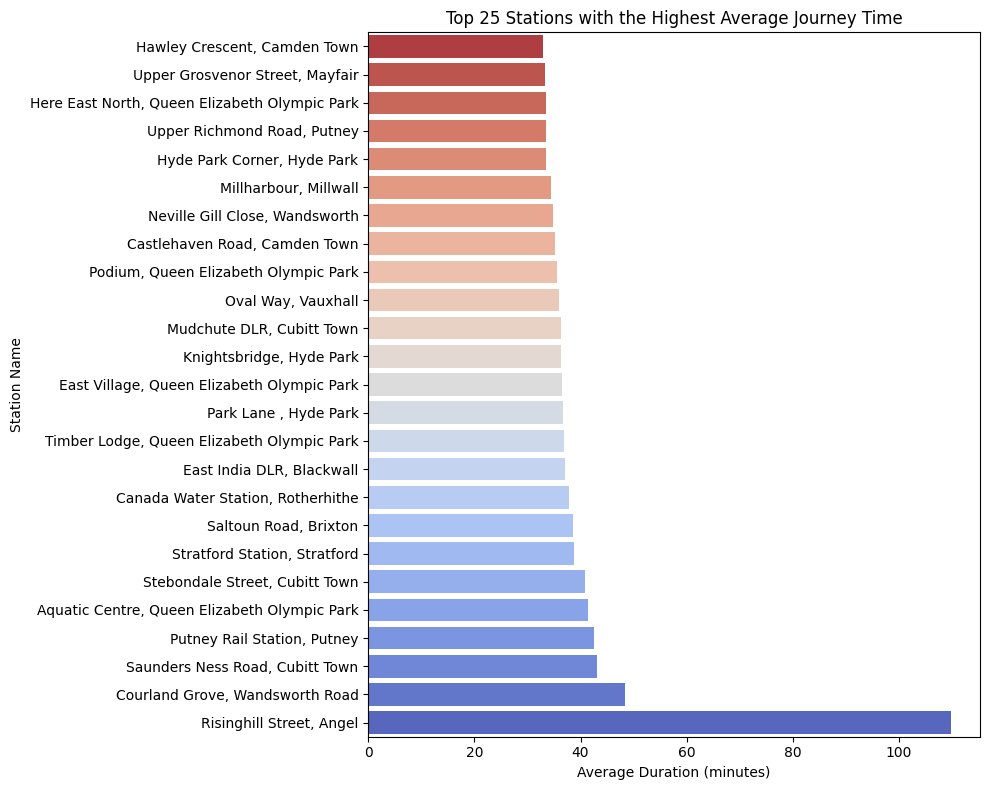

In [15]:
# SQL query to find the average journey time for each station
sql_query = """
SELECT station_name, AVG(duration) AS avg_duration
FROM (
    SELECT start_station_name AS station_name, duration
    FROM cycling_data
    UNION ALL
    SELECT end_station_name AS station_name, duration
    FROM cycling_data
) AS combined_stations
GROUP BY station_name
ORDER BY avg_duration DESC
LIMIT 25;  -- Limiting to top 10 stations for a clearer visualization
"""

cur.execute(sql_query)
rows = cur.fetchall()

# Close the database connection if necessary
# conn.close()  # Uncomment if you're done with the database for now

# Creating a DataFrame from fetched data
data = pd.DataFrame(rows, columns=['Station Name', 'Average Duration'])

# Convert durations from seconds to minutes for better readability
data['Average Duration'] = data['Average Duration'] / 60

# Creating the bar chart using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Average Duration', y='Station Name', data=data, palette='coolwarm', orient='h')  # 'orient' is set to 'h' for horizontal bars
plt.title('Top 25 Stations with the Highest Average Journey Time')
plt.xlabel('Average Duration (minutes)')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  # Ensure the station with the highest average is on top
plt.tight_layout()
plt.show()

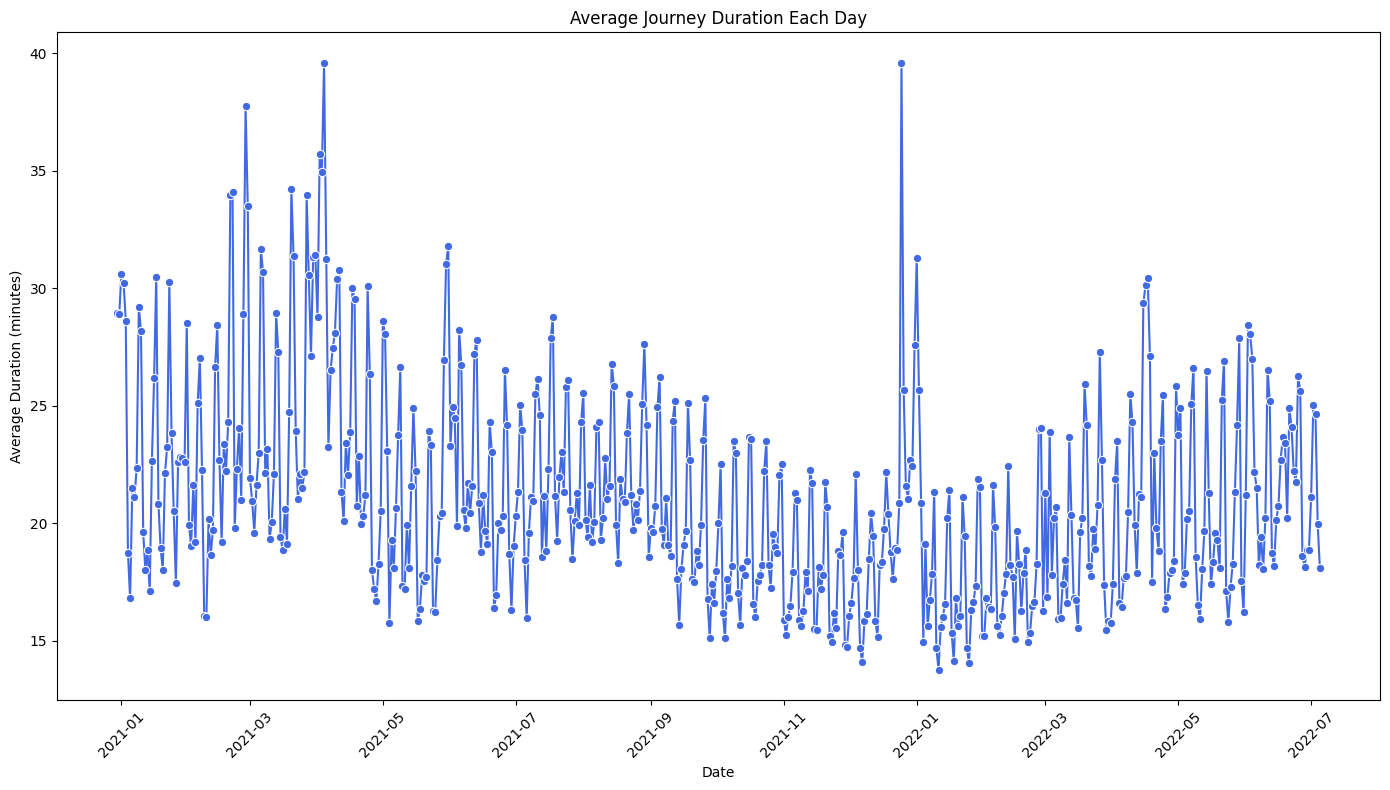

In [16]:

# SQL query to calculate the average journey duration for each day
query = """
SELECT strftime('%Y-%m-%d', substr(start_date, 7, 4) || '-' || substr(start_date, 4, 2) || '-' || substr(start_date, 1, 2)) AS journey_date, 
       AVG(duration) AS avg_duration
FROM cycling_data
GROUP BY journey_date
ORDER BY journey_date;
"""

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection

# Convert the average duration from seconds to minutes for better readability
df['avg_duration_min'] = df['avg_duration'] / 60

df['journey_date'] = pd.to_datetime(df['journey_date'])

# Seaborn plotting
plt.figure(figsize=(14, 8))  # Set the figure size for better readability
sns.lineplot(data=df, x='journey_date', y='avg_duration_min', marker='o', linestyle='-', color='royalblue')

plt.title('Average Journey Duration Each Day')
plt.xlabel('Date')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=45)  # Rotate date labels for better readability

plt.tight_layout()  # Adjust layout to make room for the plot
plt.show()


<Figure size 1400x800 with 0 Axes>

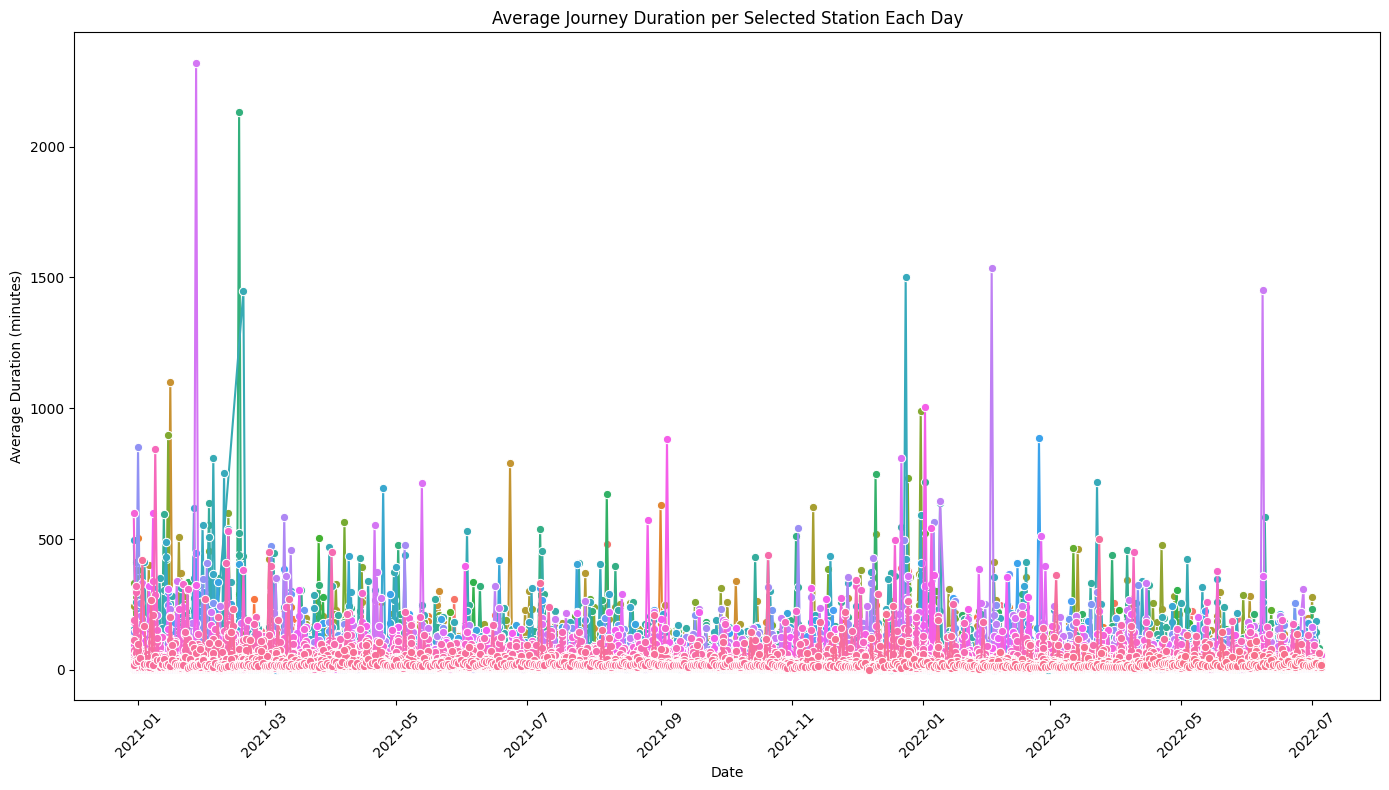

In [6]:
# SQL query to calculate the average journey duration for each station on each day
query = """
SELECT strftime('%Y-%m-%d', substr(start_date, 7, 4) || '-' || substr(start_date, 4, 2) || '-' || substr(start_date, 1, 2)) AS journey_date, 
       start_station_name, 
       AVG(duration) AS avg_duration
FROM cycling_data
GROUP BY journey_date, start_station_name
ORDER BY journey_date, start_station_name;
"""

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Convert the average duration from seconds to minutes for better readability
df['avg_duration_min'] = df['avg_duration'] / 60

# Pivot the DataFrame to have dates as rows and stations as columns
pivot_df = df.pivot(index='journey_date', columns='start_station_name', values='avg_duration_min')

# Plotting
plt.figure(figsize=(14, 8))  # Set the figure size for better readability

# Convert 'journey_date' from string to datetime for better plotting
df['journey_date'] = pd.to_datetime(df['journey_date'])


plt.figure(figsize=(14, 8))

# Use Seaborn's lineplot for plotting
# Since we're dealing with multiple lines, Seaborn will automatically create a legend for us
sns.lineplot(data=df, x='journey_date', y='avg_duration_min', hue='start_station_name', marker='o', linestyle='-').legend().remove()

plt.title('Average Journey Duration per Selected Station Each Day')
plt.xlabel('Date')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [20]:

cur.execute('''
SELECT strftime('%H', start_date) AS hour, COUNT(*) AS num_rentals
FROM cycling_data
GROUP BY hour
ORDER BY hour;
''')

results = cur.fetchall()
print("Usage by Time of Day:")
for row in results:
    print(f"Hour: {row[0]}, Rentals: {row[1]}")


Usage by Time of Day:
Hour: None, Rentals: 17074695


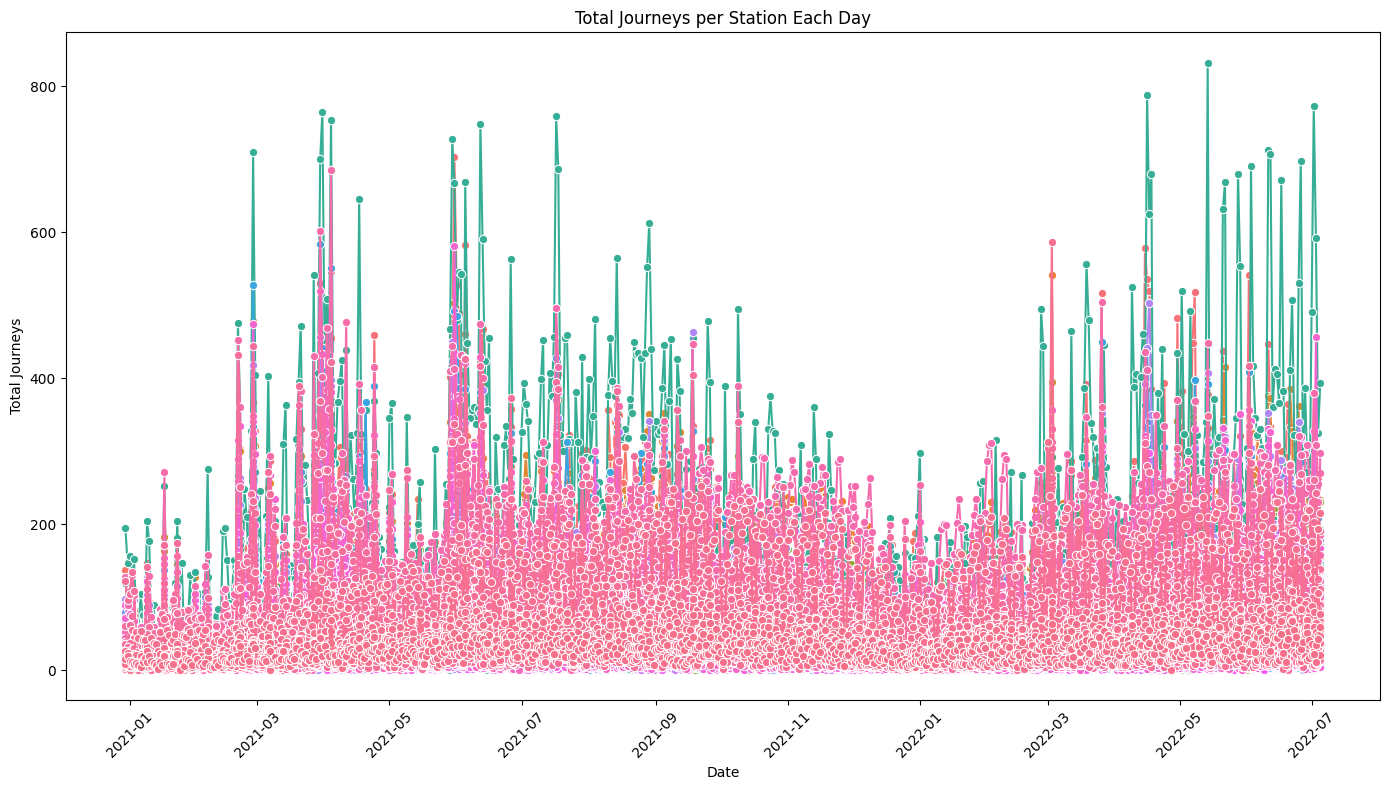

In [7]:
query = """
SELECT strftime('%Y-%m-%d', substr(start_date, 7, 4) || '-' || substr(start_date, 4, 2) || '-' || substr(start_date, 1, 2)) AS journey_date, 
       start_station_name, 
       COUNT(*) AS total_journeys
FROM cycling_data
GROUP BY journey_date, start_station_name
ORDER BY journey_date, start_station_name;
"""

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Pivot the DataFrame to have dates as rows and stations as columns
pivot_df = df.pivot(index='journey_date', columns='start_station_name', values='total_journeys')

pivot_df.index = pd.to_datetime(pivot_df.index)

# Melt the DataFrame back to long-form so it works with Seaborn's lineplot
long_df = pivot_df.reset_index().melt(id_vars='journey_date', var_name='start_station_name', value_name='total_journeys')

# Plotting using Seaborn
plt.figure(figsize=(14, 8))

# Use Seaborn's lineplot to plot each station's data. Seaborn handles multiple lines more naturally when data is in long-form.
sns.lineplot(data=long_df, x='journey_date', y='total_journeys', hue='start_station_name', marker='o', linestyle='-').legend().remove()

plt.title('Total Journeys per Station Each Day')
plt.xlabel('Date')
plt.ylabel('Total Journeys')
plt.xticks(rotation=45)  # Rotate date labels for better readability

plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [22]:
query = """
SELECT 
    strftime('%Y-%m', substr(start_date, 7, 4) || '-' || substr(start_date, 4, 2) || '-01') AS year_month, 
    start_station_name, 
    COUNT(*) AS total_journeys
FROM cycling_data
GROUP BY year_month, start_station_name
ORDER BY year_month, total_journeys DESC;
"""

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Display the first few rows of the DataFrame
print(df.head())



  year_month                            start_station_name  total_journeys
0    2020-12                   Hyde Park Corner, Hyde Park             342
1    2020-12                 Westminster Pier, Westminster             220
2    2020-12                    Wellington Arch, Hyde Park             217
3    2020-12                     Hop Exchange, The Borough             217
4    2020-12  Aquatic Centre, Queen Elizabeth Olympic Park             215


In [23]:
# Aggregate total journeys per station across all months
top_stations = df.groupby('start_station_name')['total_journeys'].sum().nlargest(20).index

# Filter the DataFrame to only include the top 5 stations
df_top_stations = df[df['start_station_name'].isin(top_stations)]

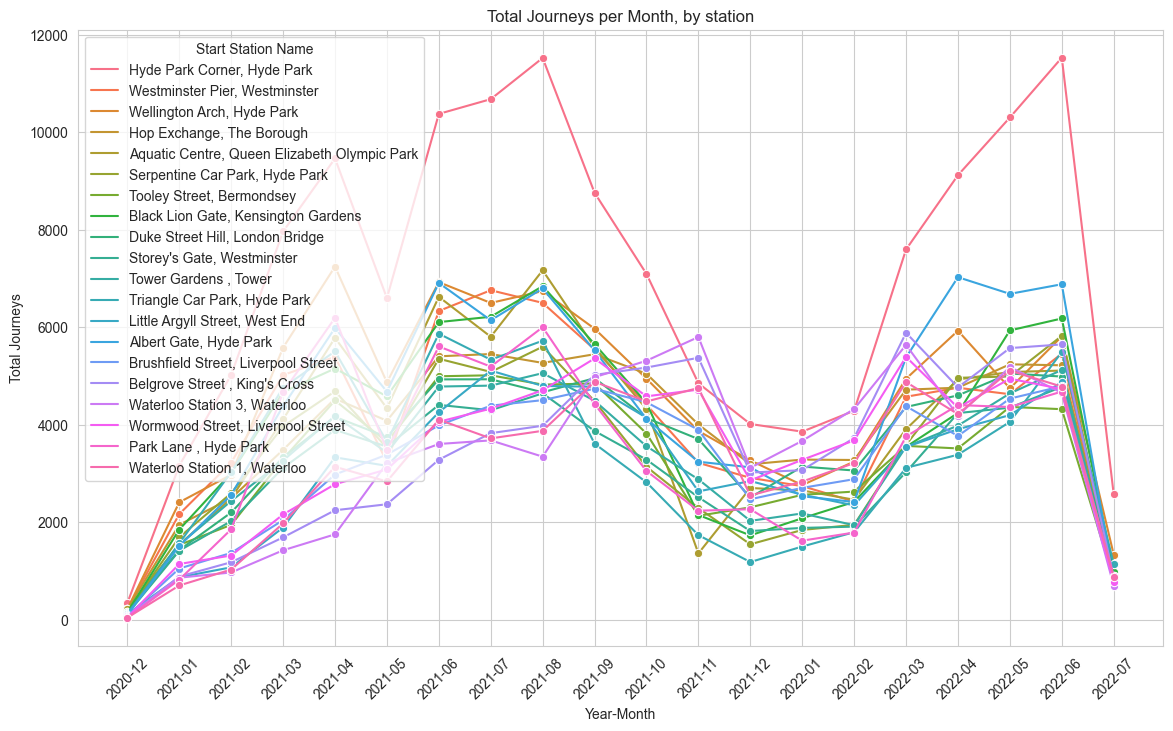

In [24]:
# Set the figure size and style for better readability
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Plotting
sns.lineplot(data=df_top_stations, x='year_month', y='total_journeys', hue='start_station_name', marker='o')

# Improve the plot
plt.title('Total Journeys per Month, by station')
plt.xlabel('Year-Month')
plt.ylabel('Total Journeys')
plt.xticks(rotation=45)
plt.legend(title='Start Station Name')

# Show plot
plt.show()


In [25]:
# SQL query to fetch required data
query = """
SELECT start_station_name, start_date, COUNT(*) AS total_journeys, AVG(duration) AS avg_duration
FROM cycling_data
GROUP BY start_station_name, start_date
ORDER BY start_station_name, start_date;
"""

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Process the DataFrame
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y %H:%M')  # Adjust format as needed
df = df.sort_values(by='start_date')
df['day_of_week'] = df['start_date'].dt.dayofweek
df['hour'] = df['start_date'].dt.hour
df['month'] = df['start_date'].dt.month
df['duration_min'] = df['avg_duration'] / 60
df['expected_revenue'] = df['total_journeys'] * (1 + (df['duration_min'] / 5))
df['station_id'] = df['start_station_name'].astype('category').cat.codes

# Here, you need actual historical data for the training to be meaningful.
# For now, I'll skip the merge with historical_data since it's empty
# If you have actual historical data, you would merge it here

# Preparing for model training
top_20_stations = df['start_station_name'].unique()[:5]  # Adjust based on your selection criteria
trained_models = {}

# Training and evaluation
for station in top_20_stations:
    station_df = df[df['start_station_name'] == station]
    # Ensure there's enough data for splitting
    if len(station_df) > 10:  # Arbitrary minimum size for training/testing
        split_index = int(len(station_df) * 0.8)
        feature_cols = ['day_of_week', 'hour', 'month', 'station_id']
        X_train = station_df.iloc[:split_index][feature_cols]
        Y_train = station_df.iloc[:split_index]['expected_revenue']
        X_test = station_df.iloc[split_index:][feature_cols]
        Y_test = station_df.iloc[split_index:]['expected_revenue']

        # Define and train models
        models = {
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'SVR': make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
        }

        for model_name, model in models.items():
            model.fit(X_train, Y_train)
            predictions = model.predict(X_test)
            mse = mean_squared_error(Y_test, predictions)
            rmse = np.sqrt(mse)
            # Store trained model and its performance metrics
            if model_name not in trained_models:
                trained_models[model_name] = {}
            trained_models[model_name][station] = {'model': model, 'RMSE': rmse}
            print(f"{model_name} at {station} - RMSE: {rmse}")


RandomForest at Claverton Street, Pimlico - RMSE: 8.525144752602833
GradientBoosting at Claverton Street, Pimlico - RMSE: 8.346174650229718
SVR at Claverton Street, Pimlico - RMSE: 8.429937127561322
RandomForest at Park Road (Baker Street), The Regent's Park - RMSE: 11.344907890301279
GradientBoosting at Park Road (Baker Street), The Regent's Park - RMSE: 10.062227086568901
SVR at Park Road (Baker Street), The Regent's Park - RMSE: 10.277915046229925
RandomForest at Belford House, Haggerston - RMSE: 13.51008852165506
GradientBoosting at Belford House, Haggerston - RMSE: 12.736544832112136
SVR at Belford House, Haggerston - RMSE: 12.708367904187284
RandomForest at Hereford Road, Bayswater - RMSE: 7.889132563742371
GradientBoosting at Hereford Road, Bayswater - RMSE: 7.326332190271264
SVR at Hereford Road, Bayswater - RMSE: 7.555390649256814
RandomForest at Westminster Pier, Westminster - RMSE: 23.170749359103556
GradientBoosting at Westminster Pier, Westminster - RMSE: 22.47924816250834

In [24]:
df


,start_station_name,start_date,total_journeys,avg_duration,day_of_week,hour,month,duration_min,expected_revenue,station_id
3061541,"Claverton Street, Pimlico",2020-12-30 00:01:00,1,1500.0,2,0,12,25.0,6.0,158
9724057,"Park Road (Baker Street), The Regent's Park",2020-12-30 00:01:00,1,360.0,2,0,12,6.0,2.2,525
1138961,"Belford House, Haggerston",2020-12-30 00:02:00,1,840.0,2,0,12,14.0,3.8,56
3061542,"Claverton Street, Pimlico",2020-12-30 00:02:00,1,1500.0,2,0,12,25.0,6.0,158
6483433,"Hereford Road, Bayswater",2020-12-30 00:02:00,1,420.0,2,0,12,7.0,2.4,343
...,...,...,...,...,...,...,...,...,...,...
9967838,"Pitfield Street North,Hoxton",2022-07-05 23:53:00,1,360.0,1,23,7,6.0,2.2,541
9700030,"Park Road (Baker Street), The Regent's Park",2022-07-05 23:53:00,1,360.0,1,23,7,6.0,2.2,525
10376874,"Queen Street 2, Bank",2022-07-05 23:54:00,1,180.0,1,23,7,3.0,1.6,565
10470650,"Queen's Gate (Central), South Kensington",2022-07-05 23:54:00,1,300.0,1,23,7,5.0,2.0,568


In [27]:
model_names = ['RandomForest', 'GradientBoosting', 'SVR']

# Initialize total revenues dictionary to store the aggregated results
total_revenues = {model: {'Total Actual': 0, 'Total Predicted': 0, 'Total Difference': 0, 'Percentage Difference': 0, 'Average RMSE': 0} for model in model_names}

# Initialize a dictionary to store all RMSE values for averaging
average_rmses = {model: [] for model in model_names}

# Initialize summed_revenues dictionary to store the aggregated actual and predicted revenues
summed_revenues = {model_name: {'Actual': {}, 'Predicted': {}} for model_name in trained_models.keys()}

# Iterate through each model and station to calculate total revenues and store RMSE values
for model_name in trained_models.keys():
    for station, details in trained_models[model_name].items():
        # Assume 'Y_test' and 'predictions' are already defined for each station as actual and predicted revenues
        actual_revenue = Y_test.sum()  # You might need to adjust this based on how Y_test is defined for each station
        predicted_revenue = details['model'].predict(X_test).sum()  # Sum of predicted revenues for the station

        # Store the actual and predicted revenues for each station
        summed_revenues[model_name]['Actual'][station] = actual_revenue
        summed_revenues[model_name]['Predicted'][station] = predicted_revenue

        # Append RMSE to the list for later averaging
        average_rmses[model_name].append(details['RMSE'])

# Aggregate total actual and predicted revenues for each model and calculate average RMSE
for model_name in trained_models.keys():
    for station in summed_revenues[model_name]['Actual']:
        total_revenues[model_name]['Total Actual'] += summed_revenues[model_name]['Actual'][station]
        total_revenues[model_name]['Total Predicted'] += summed_revenues[model_name]['Predicted'][station]

    # Calculate the total difference and percentage difference for each model
    total_difference = total_revenues[model_name]['Total Predicted'] - total_revenues[model_name]['Total Actual']
    total_revenues[model_name]['Total Difference'] = total_difference
    if total_revenues[model_name]['Total Actual'] != 0:  # Avoid division by zero
        percentage_difference = (total_difference / total_revenues[model_name]['Total Actual']) * 100
        total_revenues[model_name]['Percentage Difference'] = percentage_difference

    # Calculate and store the average RMSE for each model
    if average_rmses[model_name]:  # Ensure there are RMSE values to avoid division by zero
        average_rmse = sum(average_rmses[model_name]) / len(average_rmses[model_name])
        total_revenues[model_name]['Average RMSE'] = average_rmse

# Print out the summarized metrics for each model
for model_name, revenues in total_revenues.items():
    print(f'\nModel: {model_name}')
    print(f'Total Actual Revenue: ${revenues["Total Actual"]:.2f}')
    print(f'Total Predicted Revenue: ${revenues["Total Predicted"]:.2f}')
    print(f'Total Difference (Predicted - Actual): ${revenues["Total Difference"]:.2f}')
    print(f'Percentage Difference (Predicted - Actual): {revenues["Percentage Difference"]:.2f}%')
    print(f'Average RMSE: {revenues["Average RMSE"]:.2f}')



Model: RandomForest
Total Actual Revenue: $561333.00
Total Predicted Revenue: $409444.85
Total Difference (Predicted - Actual): $-151888.15
Percentage Difference (Predicted - Actual): -27.06%
Average RMSE: 12.89

Model: GradientBoosting
Total Actual Revenue: $561333.00
Total Predicted Revenue: $411392.75
Total Difference (Predicted - Actual): $-149940.25
Percentage Difference (Predicted - Actual): -26.71%
Average RMSE: 12.19

Model: SVR
Total Actual Revenue: $561333.00
Total Predicted Revenue: $249477.93
Total Difference (Predicted - Actual): $-311855.07
Percentage Difference (Predicted - Actual): -55.56%
Average RMSE: 12.34


In [14]:
import datetime
import pandas as pd

# Assuming 'trained_models' and 'df' are available from the previous code block

# Set up today's date features
today = datetime.datetime.now()
day_of_week = today.weekday()  # Monday is 0 and Sunday is 6
hour = today.hour  # This might be replaced with a typical hour or range of hours for prediction
month = today.month

# Prepare for predictions
today_predictions = {}

# Select the top 5 stations based on your criteria; ensure it matches with trained models
top_5_stations = df['start_station_name'].unique()[:5]  # Adjust as needed

# Iterate through each of the top 5 stations
for station in top_5_stations:
    # Ensure the station was included in the training phase
    if station in trained_models['RandomForest']:  # Assuming all models were trained on the same stations
        station_id = df.loc[df['start_station_name'] == station, 'station_id'].iloc[0]  # Get the station ID
        prediction_data = {
            'day_of_week': [day_of_week] * 24,  # Assuming prediction for each hour of the day
            'hour': list(range(24)),  # 0 to 23 for each hour of the day
            'month': [month] * 24,
            'station_id': [station_id] * 24  # Repeat station ID for all hours
        }
        prediction_df = pd.DataFrame(prediction_data)

        # Store predictions from each model
        model_predictions = {}
        
        for model_name, model_info in trained_models.items():
            model = model_info[station]['model']  # Get the trained model
            hourly_predictions = model.predict(prediction_df)
            total_day_revenue = sum(hourly_predictions)  # Sum hourly predictions to get the total for the day
            model_predictions[model_name] = total_day_revenue

        # Store the predictions for this station
        today_predictions[station] = model_predictions

# Display the predictions
for station, model_preds in today_predictions.items():
    print(f"\nStation: {station} - Predicted Revenue for {today.strftime('%Y-%m-%d')}")
    for model_name, revenue in model_preds.items():
        print(f"  {model_name}: {revenue}")



Station: Claverton Street, Pimlico - Predicted Revenue for 2024-03-01
  RandomForest: 108.5203838312222
  GradientBoosting: 166.59722946339622
  SVR: 99.22141468153258

Station: Park Road (Baker Street), The Regent's Park - Predicted Revenue for 2024-03-01
  RandomForest: 135.2554408091196
  GradientBoosting: 154.99697730621511
  SVR: 106.24253355849395

Station: Belford House, Haggerston - Predicted Revenue for 2024-03-01
  RandomForest: 114.42884166168989
  GradientBoosting: 140.22287762604523
  SVR: 91.49585379694496

Station: Hereford Road, Bayswater - Predicted Revenue for 2024-03-01
  RandomForest: 132.12636715733598
  GradientBoosting: 126.76115302583293
  SVR: 101.29694482684731

Station: Westminster Pier, Westminster - Predicted Revenue for 2024-03-01
  RandomForest: 186.1766022175488
  GradientBoosting: 209.02199746032855
  SVR: 134.45226581997161


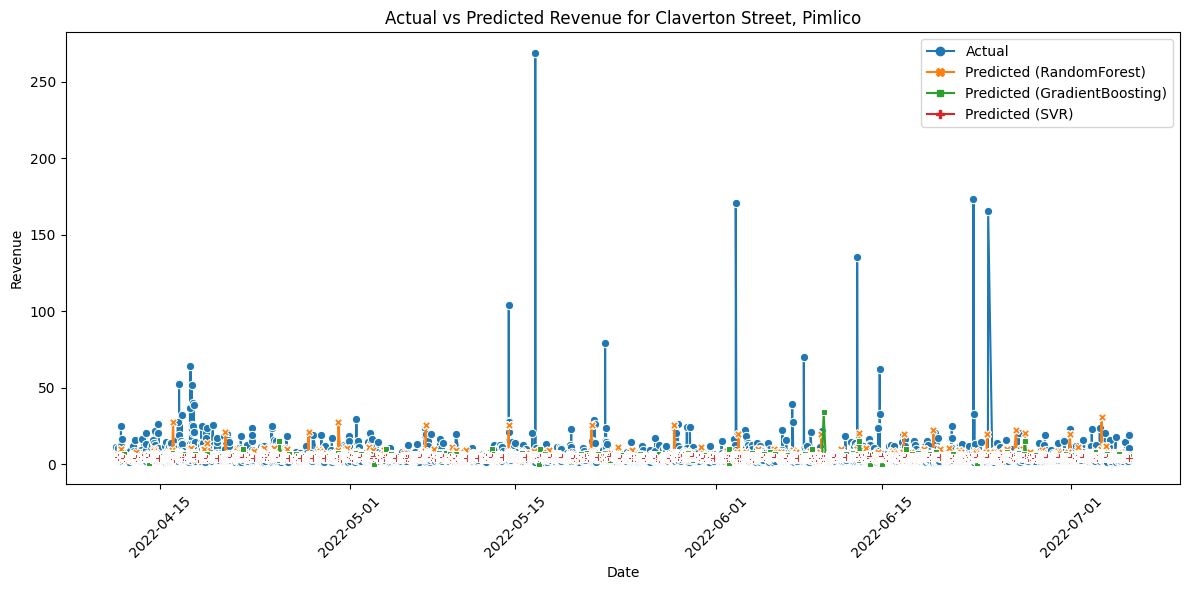

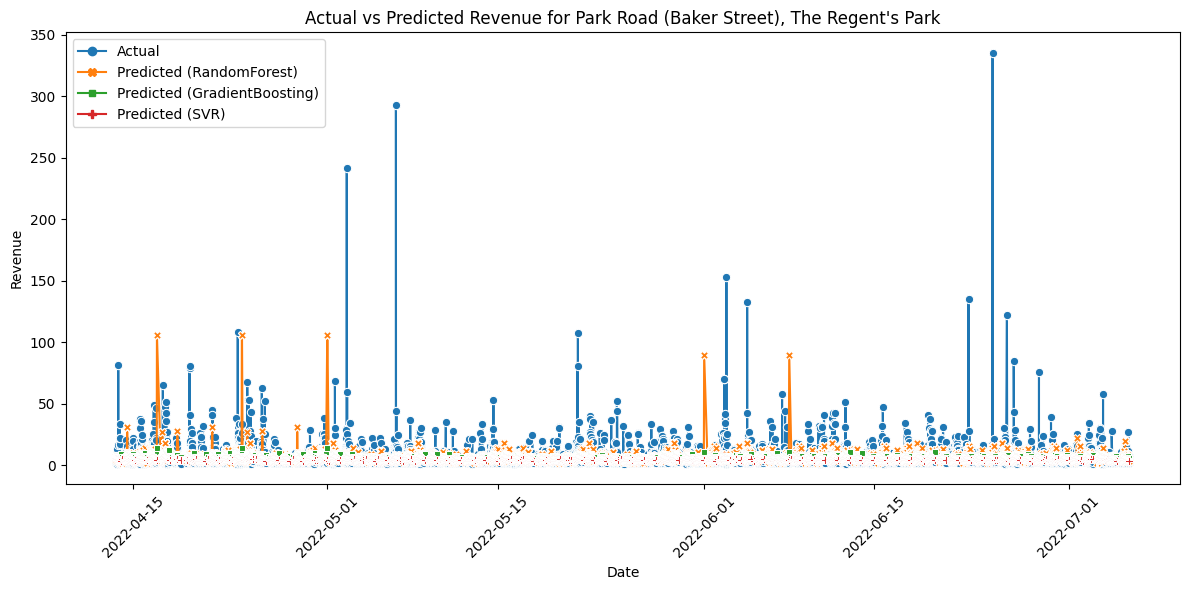

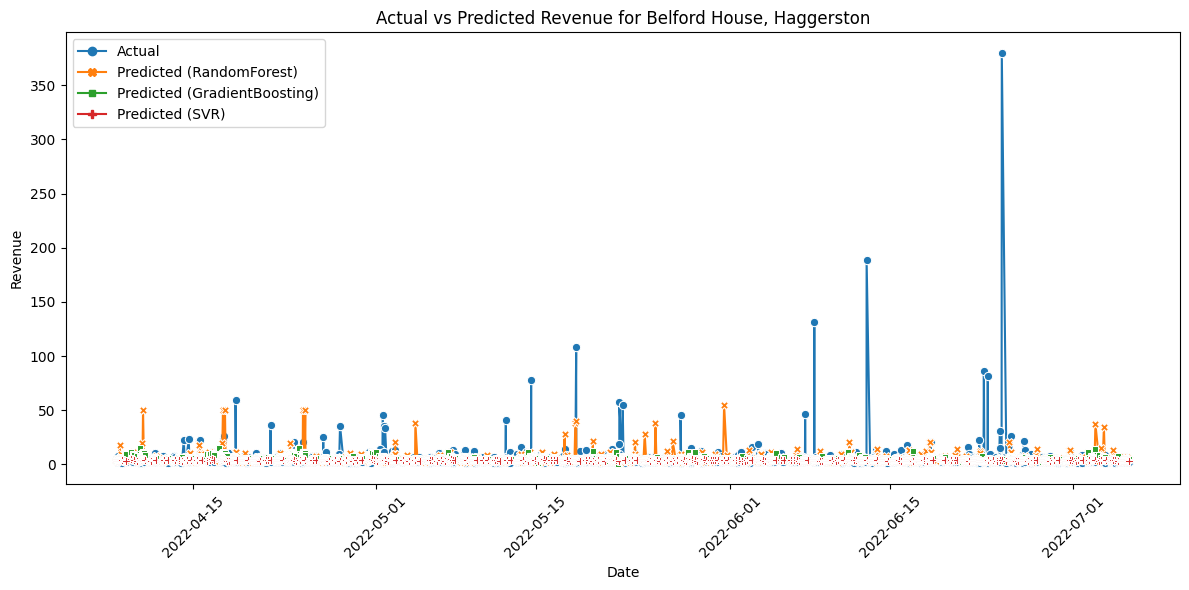

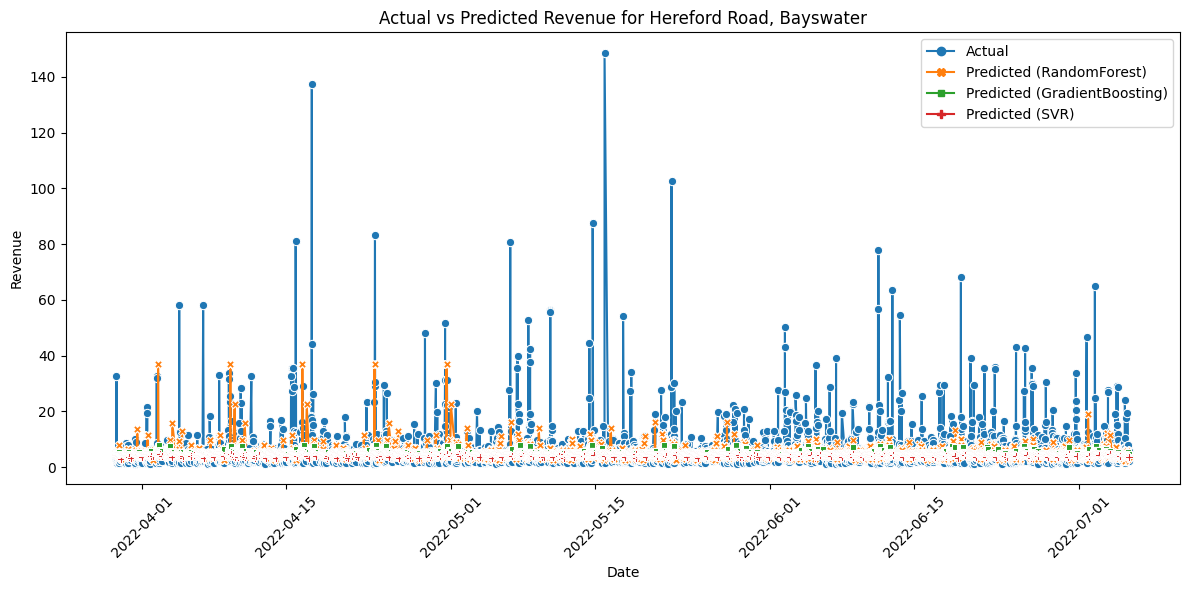

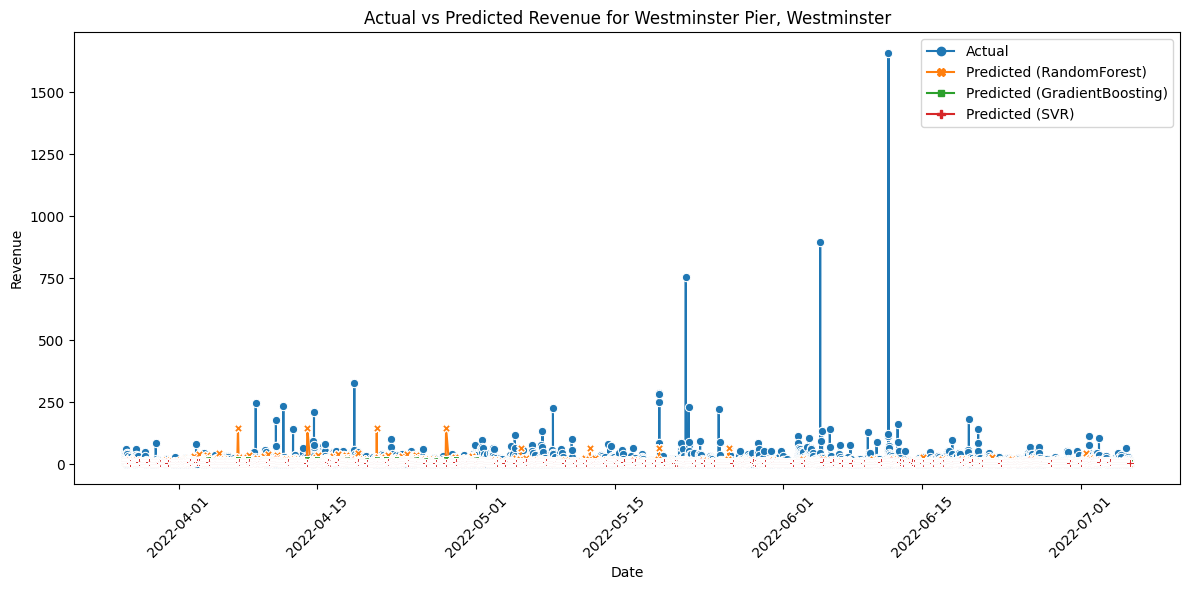

In [12]:
for station in top_20_stations:
    # Reconstruct the test DataFrame for this station
    station_df = df[df['start_station_name'] == station]
    split_index = int(len(station_df) * 0.8)
    test_df = station_df.iloc[split_index:].copy()

    # Prepare DataFrame for plotting
    melted_df = test_df[['start_date', 'expected_revenue']].copy()
    melted_df.rename(columns={'expected_revenue': 'revenue'}, inplace=True)
    melted_df['Type'] = 'Actual'  # Add a type column for distinguishing in the plot

    # Loop through each model to append predicted revenues
    for model_name in trained_models.keys():
        model = trained_models[model_name][station]['model']
        X_test = test_df[feature_cols]
        test_df[f'predicted_revenue_{model_name.lower()}'] = model.predict(X_test)

        # Append predicted data into melted_df for plotting
        temp_df = test_df[['start_date', f'predicted_revenue_{model_name.lower()}']].copy()
        temp_df.rename(columns={f'predicted_revenue_{model_name.lower()}': 'revenue'}, inplace=True)
        temp_df['Type'] = f'Predicted ({model_name})'
        melted_df = pd.concat([melted_df, temp_df])

    # Convert 'start_date' from string to datetime if it's not already
    melted_df['start_date'] = pd.to_datetime(melted_df['start_date'])

    # Plotting using Seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=melted_df, x='start_date', y='revenue', hue='Type', style='Type', markers=True, dashes=False)

    # Configure the plot with titles and labels
    plt.title(f'Actual vs Predicted Revenue for {station}')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.legend()
    plt.show()


In [ ]:
# Close the connection to the database
conn.close()
